In [22]:
from lsmulator import *
from workloads import *
import numpy as np
import matplotlib.pyplot as plt
from figure_grid import *
from bloom_assignments import *
from plot_helpers import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import matplotlib.cm as cm

In [55]:
def bary_to_cartesian(points):
  points = np.asanyarray(points)
  ndim = points.ndim # will use this to have similar output shape to input
  if ndim == 1: points = points.reshape((1,points.size))
  d = points.sum(axis=1) # in case values aren't normalized
  x = 0.5*(2*points[:,1] + points[:,2])/d
  y = (np.sqrt(3.0)/2) * points[:,2]/d
  out = np.vstack([x,y]).T
  if ndim == 1: return out.reshape((2,))
  return out

def cbm_results(trees):
  return np.array([(t.memtbl.size, t.cache.size, np.log10(t.disk_accesses)) for t in trees]).T

def plot_cbm_trisurf(trees,**kwargs):
  X,Y,Z = cbm_results(trees)
  i = Z.argmin()
  plt.gca().plot_trisurf(X,Y,Z,alpha=0.25,**kwargs)
  plt.scatter([X[i]],[Y[i]], zs=[Z[i]], s=50, c=kwargs.get('color', 'yellow'))
  plt.xlabel('Memtbl')
  plt.ylabel('Cache')
  plt.gca().set_zlabel('Disk')

def plot_cbm_contourf(trees,**kwargs):
  X,Y,Z = cbm_results(trees)
  i = Z.argmin()
  plt.tricontourf(tri.Triangulation(X,Y), Z, 100, **kwargs)
  plt.scatter(X[i],Y[i], s=50, c=kwargs.get('color', 'yellow'))
  plt.xlabel('Memtbl')
  plt.ylabel('Cache')

rt32 = np.sqrt(3)/2.

def savings_triples(trees, **kwargs):
  return np.array([(t.bigger_cache_savings(p=0.5), t.bigger_memtbl_savings(), t.bigger_bloom_savings(**kwargs)) for t in trees])

def savings_pairs(trees, **kwargs):
  preds = savings_triples(trees, **kwargs)
  maxes = preds.argmax(axis=1)
  minis = preds.argmin(axis=1)
  order = ['cache', 'memtbl', 'bloom']
  return [(order[sm], order[lg]) for sm, lg in zip(minis, maxes)]

def arrows_for(savepairs):
  redist = { ('memtbl', 'cache'): np.array([1,0]),
             ('cache', 'bloom'): np.array([-.5,.5*np.sqrt(3)]),
             ('bloom', 'memtbl'): np.array([-.5,-.5*np.sqrt(3)])}
  def arrow_for(p): return redist[p] if p in redist else -redist[p[::-1]]
  return np.array([arrow_for(p) for p in savepairs])

def plot_cbm_simplex(trees,ballocs=monkey_assignment,**kwargs):
  X,Y,Z = cbm_results(trees)
  M = min(X)+max(Y)
  i = Z.argmin()
  plt.axis('equal')
  plt.axis('off')
  C = bary_to_cartesian(np.vstack((X/M, Y/M, 1-X/M-Y/M)).T)
  arrows = arrows_for(savings_pairs(trees, ballocs=ballocs))
  plt.tricontourf(tri.Triangulation(C[:,0], C[:,1]), Z, 100, **kwargs)
  plt.quiver(C[:,0], C[:,1], arrows[:,0], arrows[:,1], color='black', alpha=0.5)
  plt.scatter(C[i,0], C[i,1], s=50, c=kwargs.get('color', 'yellow'))
  corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
  triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
  plt.triplot(triangle, linewidth=1, linestyle='--', color='black', alpha=0.1)
  plt.text(*[-0.05, 0], 'Buffer', {'ha': 'center', 'va': 'center'}, rotation=-60)
  plt.text(*[1.05, 0], 'Cache', {'ha': 'center', 'va': 'center'}, rotation=60)
  plt.text(*corners[2], 'Bloom', {'ha': 'center', 'va': 'center'})

def compare_cbm_trisurfs(monkey, baseline, ballocs=None, ax=None):
  if ax is None:
    ax = plt.subplot(111, projection='3d')
  plot_cbm_trisurf(monkey, color='blue')
  plot_cbm_trisurf(baseline, color='red')

def compare_cbm_contours(monkey, baseline, figsize=(10,4)):
  _x1,_y1, Z1 = cbm_results(monkey)
  _x2,_y2, Z2 = cbm_results(baseline)
  Zmin = min(Z1.min(), Z2.min())
  Zmax = max(Z1.max(), Z2.max())
  norm = matplotlib.colors.Normalize(Zmin, Zmax)

  fig = plt.figure(figsize=figsize)
  ax1 = plt.subplot(121)
  plt.title('Monkey')
  plot_cbm_simplex(monkey, norm=norm, ballocs=monkey_assignment)
  ax2 = plt.subplot(122)
  plt.title('Baseline')
  plot_cbm_simplex(baseline, norm=norm, ballocs=baseline_assignment)
  
  cbaxes = fig.add_axes([0.5, 0.1, 0.03, 0.8])
  m = cm.ScalarMappable()
  m.set_array(np.hstack((Z1,Z2)))
  cb = plt.colorbar(m, cax = cbaxes)



# Optimizing Allocation

In [3]:
zipf = ZipfWorkload(zipf_param=1.25)
disc = DiscoverDecayWorkload(creates=scipy.stats.poisson(10), updates=scipy.stats.poisson(8))
unif = UniformWorkload()
rrob = RoundRobinWorkload()

def optimize(workload, total_memory, assignment, dM=100):
  return LSMulator.cache_vs_bloom_vs_buf(workload, total_memory, dM=dM, ballocs=assignment)

## Running the simulation on a grid (cache-buffer-bloom, monkey & baseline)

In [4]:
zipf_monkey = optimize(zipf, 1000, monkey_assignment)
zipf_baseln = optimize(zipf, 1000, baseline_assignment)

In [10]:
disc_monkey = optimize(disc, 1000, monkey_assignment)
disc_baseln = optimize(disc, 1000, baseline_assignment)

In [11]:
unif_monkey = optimize(unif, 1000, monkey_assignment)
unif_baseln = optimize(unif, 1000, baseline_assignment)

In [12]:
rrob_monkey = optimize(rrob, 1000, monkey_assignment)
rrob_baseln = optimize(rrob, 1000, baseline_assignment)

In [28]:
def compare_results(distname):
  dist = eval(distname)
  monkey = eval(distname+'_monkey')
  baseln = eval(distname+'_baseln')
  compare_cbm_contours(monkey, baseln, figsize=(10,3))
  plt.suptitle(dist, y=1.1, fontsize=16)
  plt.show()
  compare_cbm_trisurfs(monkey, baseln)
  plt.show()

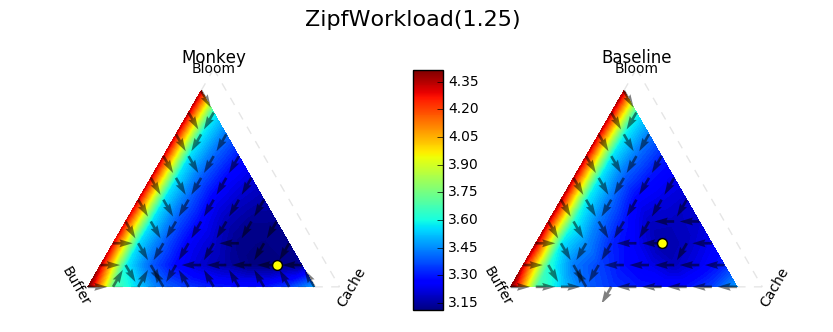

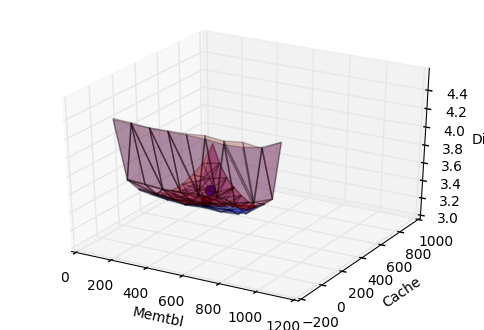

In [56]:
compare_results('zipf')

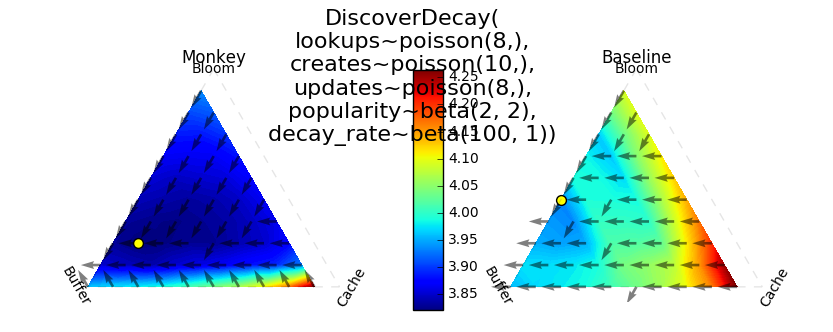

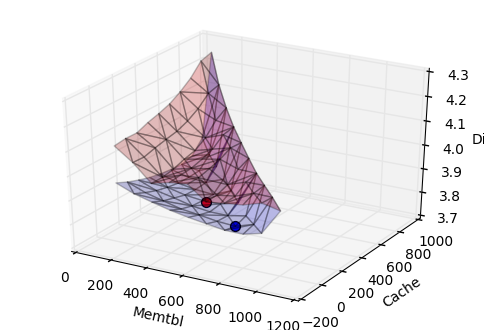

In [57]:
compare_results('disc')

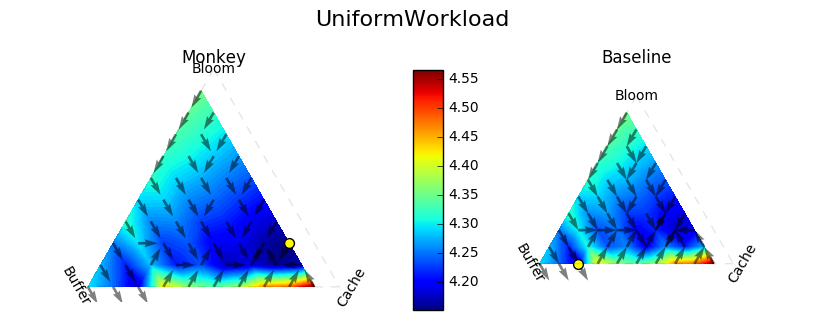

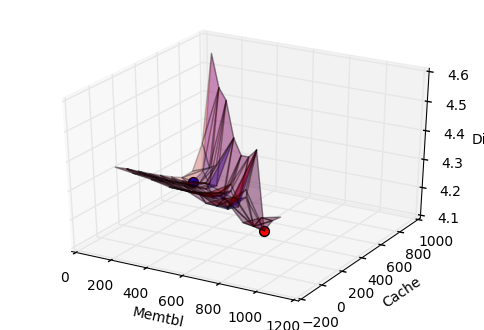

In [58]:
compare_results('unif')

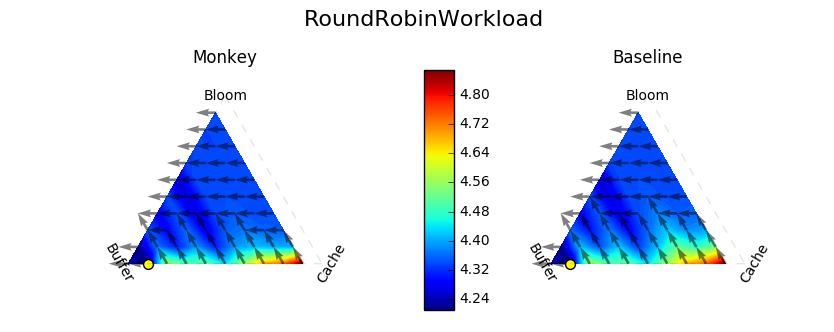

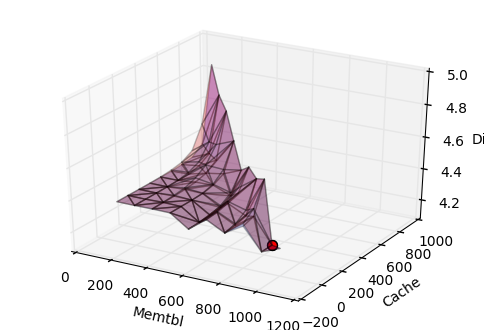

In [59]:
compare_results('rrob')

## Estimating IOs saved by enlarging cache

### What's the variance?

## Estimating IOs saved by enlarging memtable (buffer)

### What's the variance?

## Estimating IOs saved by enlarging bloom filters

### What's the variance?

## Comparing theoretical estimates to simulated results